<a href="https://www.kaggle.com/code/andreyzhyla/homework-ai?scriptVersionId=251045791" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **#Імпортуємо всі необхідні бібліотеки**

In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np

# **#1.Завантаження та трансформація зображень**

In [2]:
transformer = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.ToTensor()
])

datadir = "/kaggle/input/fruit-recognition/train/train"
dataset = torchvision.datasets.ImageFolder(datadir, transform=transformer)
print("Класи:", dataset.classes)

Класи: ['Apple Braeburn', 'Apple Granny Smith', 'Apricot', 'Avocado', 'Banana', 'Blueberry', 'Cactus fruit', 'Cantaloupe', 'Cherry', 'Clementine', 'Corn', 'Cucumber Ripe', 'Grape Blue', 'Kiwi', 'Lemon', 'Limes', 'Mango', 'Onion White', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Pepper Green', 'Pepper Red', 'Pineapple', 'Plum', 'Pomegranate', 'Potato Red', 'Raspberry', 'Strawberry', 'Tomato', 'Watermelon']


# **#2.Розбиття на train/test**

In [3]:
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))
print("Train:", len(train_dataset), "Test:", len(test_dataset))

Train: 13484 Test: 3370


# **#3.DataLoaders**

In [4]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# **#4.Візуалізація прикладів**

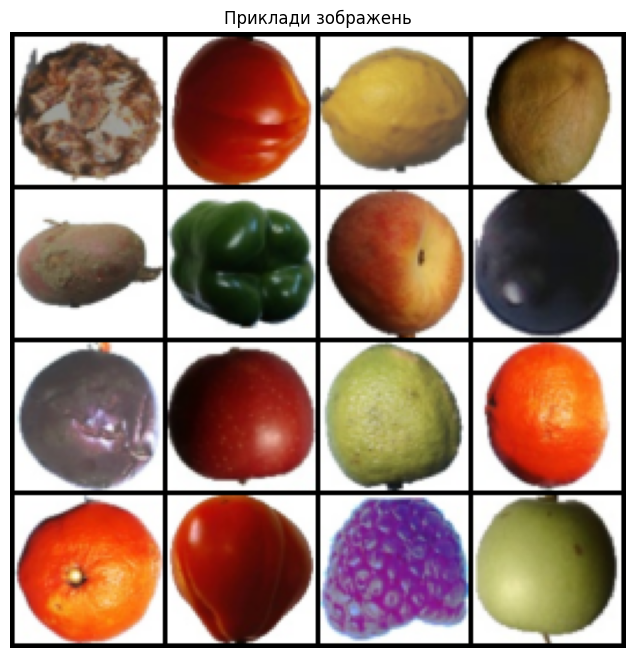

In [5]:
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images[:16], nrow=4).permute(1, 2, 0)
plt.figure(figsize=(8,8))
plt.imshow(grid)
plt.axis('off')
plt.title("Приклади зображень")
plt.show()

# **#5.Модель CNN**

In [6]:
class FruitModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 8 * 8, 200)
        self.fc2 = nn.Linear(200, len(dataset.classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> 8x32x32
        x = self.pool(F.relu(self.conv2(x)))  # -> 16x16x16
        x = self.pool(F.relu(self.conv3(x)))  # -> 32x8x8
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# **#6.Ініціалізація**

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FruitModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# **#7.Навчання**

In [ ]:
epochs = 10
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    batch_losses = []
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)
        loss = loss_fn(preds, labels)
        batch_losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = sum(batch_losses) / len(batch_losses)
    train_losses.append(train_loss)

    model.eval()
    test_loss = []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            loss = loss_fn(preds, labels)
            test_loss.append(loss.item())
    test_losses.append(sum(test_loss) / len(test_loss))

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Test Loss = {test_losses[-1]:.4f}")

# **#8.Візуалізація втрат**

In [ ]:
plt.plot(train_losses, label='Train Loss', color='green')
plt.plot(test_losses, label='Test Loss', color='red')
plt.title("Графік втрат")
plt.xlabel("Епоха")
plt.ylabel("Втрата")
plt.legend()
plt.grid(True)
plt.show()

# **#9.Метрики та матриця плутанини**

In [ ]:
true_labels = []
pred_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        pred_labels.extend(preds)
        true_labels.extend(labels.numpy())

# **#Матриця плутанини**

In [ ]:
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
plt.figure(figsize=(15, 15))
disp.plot(xticks_rotation=90, cmap="Blues")
plt.title("Матриця плутанини")
plt.show()

# **# Confusion matrix**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# **# Перевірка моделі на тестових даних**

In [ ]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# **# Матриця неточностей (confusion matrix)**

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# **#Класифікаційний звіт**

In [ ]:
print("Класифікаційний звіт:")
print(classification_report(true_labels, pred_labels, target_names=dataset.classes))